In [31]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import pickle
import yaml
from nuance.star import Star

methods = {
    "bls_bspline": "bspline + BLS",
    "bls_wotan3D": "biweight + BLS",
    "bls_harmonics": "harmonics + BLS",
    "bens": "sinusoids + BLS (Ben's)",
    "nuance": "nuance",
}


targets = [int(Path(f).stem) for f in glob("../figures/searched/*")]

result_df = pd.DataFrame(columns=targets)

def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        % period
        < 0.01
    )
    period_check = np.abs(period - true_period) <= 0.01
    alias_check = np.abs(2 * period - true_period) <= 0.01
    alias_check |= np.abs(period / 2 - true_period) <= 0.01
    if period_check:
        return 1
    elif alias_check:
        return .5
    else:
        return 0

In [80]:
from collections import defaultdict

true_positives = defaultdict(list)
false_positives = defaultdict(list)

per_target_true_positives = []
per_target_false_positives = []

snr_limit = 5

for target in targets:
    info = yaml.safe_load(open(f"../data/{target}/info.yaml", "r"))
    star = Star(info["star_radius"], info["star_mass"])

    _per_target_true_positives = []
    _per_target_false_positives = []

    for method in methods:
        df = pd.read_csv(    
            f"../data/{target}/recovered/{method}/results.csv", index_col=0
        )
        cleaned = pickle.load(open(f"../data/{target}/cleaned.fluxes", "rb"))
        true_snr = df.apply(lambda row: star.snr(row["period"], row["radius"], len(cleaned["flux"]), np.median(cleaned["error"])), axis=1)
        snr = df["snr"]

        period_ok = df.apply(
            lambda row: right_candidate(
                0, row["period"], 0, row["true_period"]
            ),
            axis=1,
        ) > 0
        snr_ok = (true_snr >= snr_limit) & (snr >= snr_limit)
        tp =  period_ok & snr_ok
        true_positives[method].append(np.array([df.tau.values, df.delta.values, tp, true_snr>snr_limit]).T)

        fp = snr_ok & ~period_ok
        false_positives[method].append(np.array([df.tau.values, df.delta.values, fp]).T)

        _per_target_true_positives.append(np.sum(tp))
        _per_target_false_positives.append(np.sum(fp))

    per_target_true_positives.append(_per_target_true_positives)
    per_target_false_positives.append(_per_target_false_positives)


true_positives = {k: np.concatenate(v).T for k, v in true_positives.items()}
false_positives = {k: np.concatenate(v).T for k, v in false_positives.items()}
per_target_true_positives = np.array(per_target_true_positives)
per_target_false_positives = np.array(per_target_false_positives)


In [87]:
has_best_tp = np.all(per_target_true_positives[:, -1][:, None] >= per_target_true_positives[:, 0:-1], axis=1)
has_best_fp = np.all(per_target_false_positives[:, -1][:, None] <= per_target_false_positives[:, 0:-1], axis=1)

In [88]:
per_target_false_positives

array([[15,  9,  1,  1,  1],
       [13,  0, 10, 13,  2],
       [11,  4,  4,  4,  4],
       ...,
       [17, 20,  7, 10,  3],
       [11, 13, 10, 14,  7],
       [12,  5,  6,  3,  2]])

In [93]:
has_best_tp.mean(), has_best_fp.mean(), (has_best_tp & has_best_fp).mean()

(0.8904109589041096, 0.6963470319634704, 0.6598173515981736)

In [69]:
per_target_true_positives = np.array(per_target_true_positives)

In [64]:
np.mean([true_positives[method][2]] for method in methods)

TypeError: unsupported operand type(s) for /: 'generator' and 'int'

In [63]:
true_positives["nuance"][1]

array([[6.46659066, 4.1170373 , 3.42169094, ..., 5.26284852, 4.67579234,
        4.28567062],
       [4.31971636, 4.31971636, 4.31971636, ..., 0.83002733, 0.83002733,
        0.83002733],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/3567418023.py:7: RuntimeWarning: invalid value encountered in divide
  nuance = np.histogram(true_positives["nuance"][:, true_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/3567418023.py:8: RuntimeWarning: invalid value encountered in divide
  others = [np.histogram(true_positives[method][:, true_positives[method][2] == 1.][i], bins=bins, density=False)[0] for method in methods if method != "nuance"]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/3567418023.py:51: RuntimeWarning: invalid value encountered in divide
  nuance = np.histogram(false_positives["nuance"][:, false_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/3567418023.py:52: RuntimeWarning: invalid value encountered in divide
  others = [np.histogram(false_positives[method][:, false_positives[me

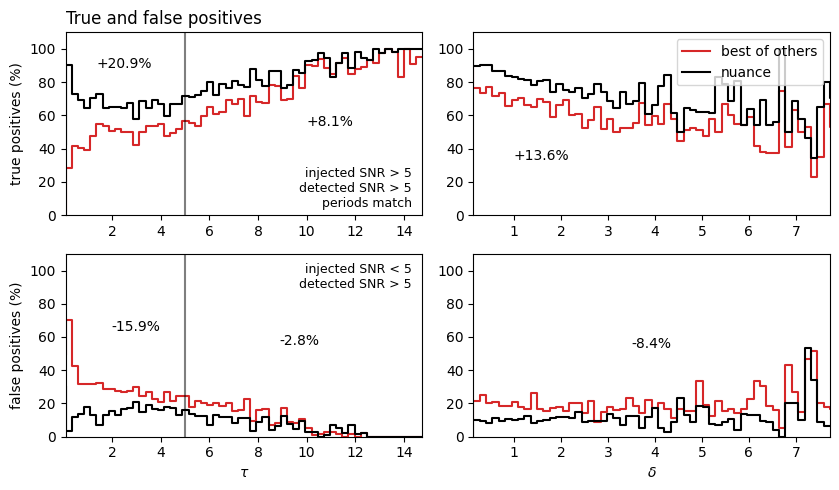

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8.5, 5))

def plot(i, bins, legend=False):
    total = np.histogram(true_positives["nuance"][i][true_positives["nuance"][-1].astype(bool)], bins=bins)[0]
    nuance = np.histogram(true_positives["nuance"][:, true_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
    others = [np.histogram(true_positives[method][:, true_positives[method][2] == 1.][i], bins=bins, density=False)[0] for method in methods if method != "nuance"]/total
    others_max = np.max(others, axis=0)
    plt.step(bins[0:-1], others_max*100, c="C3", label="best of others" if legend else None)
    plt.step(bins[0:-1], nuance*100, c="k", label="nuance" if legend else None)
    # plt.step(bins[0:-1], (nuance-others_max)*100, c=diff_color, label="difference" if legend else None)
    # plt.fill_between(bins[0:-1], 0, (nuance-others_max)*100, step="pre", color=diff_color, alpha=0.2)
    return nuance, others_max

n = 60
text_y_pos = 0.2
diff_color = "k"
tau_lim = 5
tau_bins = np.linspace(0.1, 15, n)

###
plt.subplot(221)
plt.title("True and false positives", loc="left")

nuance, others_max = plot(0, tau_bins)
# plt.xlabel(r"$\tau$")
plt.ylabel("true positives (%)")
plt.ylim(0,110)
plt.xlim(tau_bins[0], tau_bins[-2])
plt.axvline(tau_lim, c=diff_color, alpha=0.5)
mask = tau_bins[:-1] < tau_lim
plt.text(2.5, 95 , f"+{np.nanmean((nuance-others_max)[mask])*100:.1f}%", va="top", ha="center", color=diff_color)
plt.text(10, 60, f"+{np.nanmean((nuance-others_max)[~mask])*100:.1f}%", va="top", ha="left", color=diff_color)
plt.text(0.97, 0.03, f"injected SNR > {snr_limit}\n detected SNR > {snr_limit}\nperiods match", va="bottom", ha="right", color=diff_color, transform=plt.gca().transAxes, fontsize=9)

plt.subplot(222)
bins = np.linspace(0, 8, n)
nuance, others_max = plot(1, bins, legend=True)
# plt.xlabel(r"$\delta$")
plt.legend()
plt.ylim(0,110)
plt.xlim(bins[1], bins[-3])
plt.tight_layout()
plt.text(1, 40, f"+{np.nanmean((nuance-others_max))*100:.1f}%", va="top", ha="left", color=diff_color)
plt.legend(loc="upper right")


def plot(i, bins):
    total = np.histogram(false_positives["nuance"][i], bins=bins)[0]
    nuance = np.histogram(false_positives["nuance"][:, false_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
    others = [np.histogram(false_positives[method][:, false_positives[method][2] == 1.][i], bins=bins, density=False)[0] for method in methods if method != "nuance"]/total
    others_min = np.min(others, axis=0)
    plt.step(bins[0:-1], others_min*100, c="C3", label=None)
    plt.step(bins[0:-1], nuance*100, c="k", label=None)
    # plt.step(bins[0:-1], -(nuance-others_max)*100, c=diff_color)
    # plt.fill_between(bins[0:-1], 0, -(nuance-others_max)*100, step="pre", color=diff_color, alpha=0.2)
    return nuance, others_min

text_y_pos = 0.8

###
plt.subplot(223)
nuance, others_max = plot(0, tau_bins)
plt.xlabel(r"$\tau$")
plt.ylabel("false positives (%)")
plt.ylim(0,110)
plt.xlim(tau_bins[0], tau_bins[-2])
plt.axvline(tau_lim, c=diff_color, alpha=0.5)
mask = tau_bins[:-1] < tau_lim
plt.text(3, 70, f"{np.nanmean((nuance-others_max)[mask])*100:.1f}%", va="top", ha="center", color=diff_color)
plt.text(0.6, text_y_pos*0.7, f"{np.nanmean((nuance-others_max)[~mask])*100:.1f}%", transform=plt.gca().transAxes, va="top", ha="left", color=diff_color)
plt.text(0.97, 0.95, f"injected SNR < {snr_limit}\n detected SNR > {snr_limit}", va="top", ha="right", color=diff_color, transform=plt.gca().transAxes, fontsize=9)

plt.subplot(224)
bins = np.linspace(0, 8, n)
nuance, others_max = plot(1, bins)
plt.xlabel(r"$\delta$")
plt.ylim(0,110)
plt.xlim(bins[1], bins[-3])
plt.text(3.5, 60, f"{np.nanmean((nuance-others_max))*100:.1f}%", va="top", ha="left", color=diff_color)

plt.tight_layout()
# plt.savefig("../figures/true_false_positive.pdf")

In [76]:
mask = (true_positives["nuance"][0] < 6) & (true_positives["nuance"][1] < 8)
(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"]))


IndexError: invalid index to scalar variable.

In [81]:
(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"])).shape

ValueError: operands could not be broadcast together with shapes (11075,) (0,) 

In [75]:
np.hstack(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"]))

array([ 0.,  0., -1., ...,  0.,  0.,  0.])

In [79]:
(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"]))[mask]

IndexError: invalid index to scalar variable.

In [78]:
[mask]

[array([False,  True,  True, ...,  True,  True,  True])]

In [68]:
true_positives["bens"]

array([[6.46659066, 3.38046173, 2.75017873, ..., 4.23000626, 3.72738507,
        3.40153903],
       [2.57089382, 2.57089382, 2.57089382, ..., 0.41736812, 0.41736812,
        0.41736812],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [67]:
true_positives["nuance"]

array([[6.46659066, 3.38046173, 2.75017873, ..., 4.23000626, 3.72738507,
        3.40153903],
       [2.57089382, 2.57089382, 2.57089382, ..., 0.41736812, 0.41736812,
        0.41736812],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [66]:
np.mean(np.max([false_positives[method][-1] for method in methods if method != "nuance"], 0)) - np.mean(false_positives["nuance"][-1])

0.468352144469526